---
title: SWOT HR elevation comparison to ICESat-2
thumbnail: ../img/swot.png
date: 2025-09-11
github: https://github.com/cryointhecloud/CryocloudWebsite
subject: Tutorial
authors:
  - name: Zachary Katz
    affiliations:
      - id: CSM
        institution: Colorado School of Mines
        department: Department of Geophysics
    email: zachary_katz@mines.edu
    corresponding: true
    github: zsk4
    orcid: 0009-0006-2779-7103
  - name: Tasha Snow
    affiliations:
      - University of Maryland
      - NASA Goddard Space Flight Center
      - CSM
    email: tsnow03@umd.edu
    orcid: 0000-0001-5697-5470
license: MIT
---

# Overview

In this tutorial, we’ll plot NASA/CNES's **Surface Water and Ocean Topography (SWOT)** High Resolution (HR) and Low Resolution (LR) coverage throughout Antarctica, then compare SWOT elevations to NASA’s **Ice, Cloud, and Land Elevation Satellite-2 (ICESat-2)** over the Bach Ice Shelf (Antarctic Peninsula) to verify that geophysical corrections have been correctly applied.

:::{admonition} Run next **8 code cells** (gray text blocks) to get it processing while we talk
:class: danger
Stop when you get to "Compare SWOT and ICESat-2 elevations on Bach Ice Shelf" heading 
:::

::::{admonition} Learning Objectives
:class: hint

By the end of this tutorial, you will be able to:

- Plot SWOT Low Resolution (LR) and High Resolution (HR) availability over Antarctica  
- Obtain spatially coincident ICESat-2 land ice elevations (ATL06) and SWOT HR data  
- Correct for differing geophysical corrections between missions  
- Correct for ice advection between acquisitions  
- Plot a comparison of ICESat-2 and SWOT elevations over Bach Ice Shelf, Antarctic Peninsula
::::

::::{admonition} Prerequisites
:class: tip
- An [**Earthdata Login**](https://urs.earthdata.nasa.gov/) (free)
- [SWOT HR data access tutorial](https://book.cryointhecloud.com/swot-hr-access)
::::

::::{admonition} Who is this for?
:class: tip
- **Beginners:** You’ll get a gentle, step-by-step start with cloud data.  
- **Experts:** You can skim to the code and links; advanced **Notes** are flagged along the way.
::::

# Visualize SWOT LR and HR coverage over Antarctica
Building on the previous [**SWOT HR data access tutorial**]() where we learned how to find and open SWOT data, we’ll now focus on what’s available for our ICESat-2 comparison. In this step, you’ll create an interactive map of SWOT coverage over Antarctica.

:::{admonition} What you’ll do
:class: hint
1. Ensure required packages and local data folders exist  
2. Retrieve or reuse local copies of:
   - **Scripps Antarctica polygons** (grounded ice / ice shelves)
   - **SWOT HR seasonal/per-pass KML** (culled to south of 60°S)
   - **SWOT LR orbit KMZ**  
3. Reproject to South Polar Stereographic (**EPSG:3031**)  
4. Plot a clear availability map with legend, colors, and title
:::

::::{admonition} Data sources used
:class: seealso
**SWOT orbit files**
- **SWOT HR Nominal Mask (Northern Hemisphere summer 2025 KML)** — from [PO.DAAC](https://podaac.jpl.nasa.gov/SWOT-events/SWOT_events.html)  \
  <https://podaac.jpl.nasa.gov/SWOT-events/swot_science_hr_Mar2025-v10_perPass.kml>  
  *Note:* PO.DAAC also publishes other HR masks; feel free to swap in a newer/older KML as desired.
- **SWOT LR orbit (KMZ)** — from [AVISO/CNES](https://www.aviso.altimetry.fr/en/missions/current-missions/swot/orbit.html) \
  <https://www.aviso.altimetry.fr/fileadmin/documents/missions/Swot/swot_science_orbit_sept2015-v2_10s.kmz>

**Other data**
- **Scripps Antarctica polygons** — from the supplement of [M.A. Depoorter et al., 2013](https://doi.pangaea.de/10.1594/PANGAEA.819147) \
<https://doi.pangaea.de/10013/epic.42133.d001>
::::
:::{note} On KML/KMZ Files
:class: dropdown
The orbit files are hosted in different locations and as different file types; because this tutorial downloads the orbit files directly from the source locations, the HR comes as a KML and LR orbit as a KMZ. A KMZ file is just a zipped version of KML that can typically be read by the same programs designed to read KML files (e.g., Fiona, Google Earth).
:::

## Package imports and data paths needed to get started

In [37]:
%matplotlib widget

from pathlib import Path
import io, zipfile, tempfile, os
import warnings
import requests
import fiona
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
import cartopy.crs as ccrs

# Quiet noisy driver warnings (optional)
warnings.filterwarnings("ignore", message=".*ERROR parsing kml Style: No id.*", category=RuntimeWarning)

In [38]:
# --- Paths ---

# A shared folder on CryoCloud / local machine
DATADIR = Path("/home/jovyan/shared/SWOT/data")  # adjust if needed
DATADIR.mkdir(parents=True, exist_ok=True)

# CryoCloud file targets
GL_SHP = DATADIR / "Antarctica_masks" / "scripps_antarctica_polygons_v1.shp"
HR_KML = DATADIR / "hr_Mar2025_below60S.kml"   # culled HR KML we’ll create if missing
LR_KMZ = DATADIR / "lr_Sept2015.kmz"           # LR orbit

# Source URLs (try HR 2025, fall back to 2024 seasonal if needed)
HR_URLS = [
    "https://podaac.jpl.nasa.gov/SWOT-events/swot_science_hr_Mar2025-v10_perPass.kml",
    "https://podaac.jpl.nasa.gov/SWOT-events/swot_science_hr_Nov2024-v09-seasonal_perPass.kml",
]
LR_URL = "https://www.aviso.altimetry.fr/fileadmin/documents/missions/Swot/swot_science_orbit_sept2015-v2_10s.kmz"

# Scripps polygons zip (contains multiple shapefile components)
GL_ZIP_URL = "https://doi.pangaea.de/10013/epic.42133.d001"

# Bach Ice Shelf bounding box location in South Polar Stereographic [ESPG: 3031]
bach = [-1920000, 480000, -1740000, 680000]

::::{admonition} Data read-in helper functions to keep the tutorial cells small and readable
:class: tip
- `download_bytes` wraps robust HTTP downloads with timeouts.
- `ensure_scripps_polygons` fetches and unzips the Scripps shapefiles if missing.
- `read_all_kml_layers` merges *all* non-empty KML/KMZ layers into one GeoDataFrame—KMLs often have multiple named layers.
- `save_kml` writes a cleaned/culled KML for quick reuse.
::::

In [39]:
# --- Small helper functions ---

def download_bytes(url: str) -> bytes:
    r = requests.get(url, timeout=180)
    r.raise_for_status()
    return r.content

def ensure_scripps_polygons(gl_shp_path: Path, source_zip_url: str) -> None:
    """Download & extract the Scripps Antarctica polygons if missing."""
    if gl_shp_path.exists():
        return
    gl_shp_path.parent.mkdir(parents=True, exist_ok=True)
    print("Downloading Scripps Antarctica polygons…")
    content = download_bytes(source_zip_url)
    with zipfile.ZipFile(io.BytesIO(content)) as zf:
        zf.extractall(gl_shp_path.parent)
    print(f"Extracted to: {gl_shp_path.parent}")

def read_all_kml_layers(path: Path, driver="KML") -> gpd.GeoDataFrame:
    """Load all non-empty KML/KMZ layers into a single GeoDataFrame."""
    layers = fiona.listlayers(str(path))
    frames = []
    for lyr in layers:
        try:
            gdf = gpd.read_file(path, driver=driver, layer=lyr)
            if not gdf.empty:
                frames.append(gdf)
        except Exception as exc:
            print(f"Skipped layer '{lyr}': {exc}")
    if not frames:
        raise RuntimeError(f"No valid layers in {path}")
    return gpd.GeoDataFrame(pd.concat(frames, ignore_index=True))

def save_kml(gdf: gpd.GeoDataFrame, out_path: Path) -> None:
    """Save a GeoDataFrame as KML (for future reuse)."""
    out_path.parent.mkdir(parents=True, exist_ok=True)
    gdf.to_file(out_path, driver="KML")

::::{admonition} Read in the Scripps Antarctic basemap for our map
:class: tip
- Auto download the file if not already present (we did this for you to save time, but code is here in case you need it later)
- Load the Scripps polygons and reproject to **EPSG:3031**.  
- If the `Id_text` field is present, split **grounded ice/land** vs **ice shelves** for clearer styling in the map.
::::

In [40]:
# --- Ensure basemap (Scripps polygons) is available ---
ensure_scripps_polygons(GL_SHP, GL_ZIP_URL)

# Load and prep Scripps polygons
gl_gdf = gpd.read_file(GL_SHP)
# Reproject to EPSG:3031 (Antarctic Polar Stereographic)
gl_gdf_3031 = gl_gdf.to_crs(epsg=3031)

# Split out grounded ice vs ice shelves for nicer styling
name_field = "Id_text" if "Id_text" in gl_gdf_3031.columns else None
if name_field is None:
    # Fall back to plotting all polygons uniformly if classification is missing
    grounded_3031 = gl_gdf_3031
    shelves_3031 = gpd.GeoDataFrame(geometry=[])
else:
    grounded_classes = {"Grounded ice or land", "Isolated island", "Ice rise or connected island"}
    grounded_3031 = gl_gdf_3031[gl_gdf_3031[name_field].isin(grounded_classes)]
    shelves_3031  = gl_gdf_3031[gl_gdf_3031[name_field] == "Ice shelf"]

::::{admonition} Open KML: SWOT HR coverage
:class: tip

We **cull the HR mask south of 60°S** to speed up plotting by removing HR regions not relevant to Antarctica (**already done**). 

- We download the HR orbital file to a temporary location where it deletes as soon as we leave the FOR loop. This minimizes data storage to save money.
- Some layers include “**Nadir**” features; we drop them for a cleaner availability view.
- We save the culled HR KML locally as `hr_Mar2025_below60S.kml` so the next run is instant.
::::
:::{note} On culling the HR mask
:class: dropdown
We are able to cull the HR mask to below 60°S because each segment of HR data is discontinuous from other segments even if they are part of the same pass, resulting in the ability to filter for segments using bounding box criteria. Because the LR orbit file is split by pass, each pass contains data below 60°S and cannot easily be culled in the same way. If you run the culling yourself it can take ~23 minutes on CryoCloud.
:::


In [42]:
# --- Ensure SWOT HR coverage (culled to south of 60S) exists in CryoCloud ---
# Note: This process takes 23 min if not already completed
if not HR_KML.exists():
    for url in HR_URLS:
        try:
            # Download HR orbital file into temp
            print(f"Trying HR KML: {url}")
            with tempfile.TemporaryDirectory() as tdir:
                kml_path = Path(tdir) / "hr.kml"
                kml_path.write_bytes(download_bytes(url))
            
                hr_all = read_all_kml_layers(kml_path, driver="KML") # with some KMZ/KML may need to use driver="LIBKML"
                hr_all = hr_all.assign(miny=hr_all.geometry.bounds.miny)
                # Cull below 60 S
                hr_south = hr_all[hr_all["miny"] < -60].drop(columns=["miny"])
                if "Name" in hr_south.columns:
                    # Remove nadir coverage to keep only KaRIn's
                    hr_south = hr_south[~hr_south["Name"].str.contains("Nadir", na=False)]
                save_kml(hr_south, HR_KML)
            print(f"Saved culled HR KML: {HR_KML}")
            break
        except Exception as exc:
            print(f"Failed HR download/parse from {url}: {exc}")
    else:
        raise RuntimeError("Could not obtain a usable SWOT HR KML.")


::::{admonition} Ensure LR orbit file exists
:class: tip
- The LR orbit is provided as **KMZ**. Most environments can read it via driver `"KML"`.  
::::

In [43]:
# --- Ensure SWOT LR orbit exists in CryoCloud ---
if not LR_KMZ.exists():
    print("Downloading SWOT LR KMZ…")
    LR_KMZ.write_bytes(download_bytes(LR_URL))
    print(f"Saved: {LR_KMZ}")

::::{admonition} Load, reproject & filter
:class: tip
- We merge all HR and LR layers, remove “Nadir” features when present in LR, and reproject both HR and LR GeoDataFrames to **EPSG:3031**, the same projection as the Scripps Antarctic basemap.
- Loading takes ~6 min because the LR file contains all 584 SWOT passes!
::::

In [35]:
# --- Load HR/LR coverages and reproject to EPSG:3031 ---

# HR (already culled), stored as KML
hr_gdf = read_all_kml_layers(HR_KML, driver="KML")
hr_3031 = hr_gdf.to_crs(epsg=3031)

# LR (KMZ) — many GDAL/Fiona builds can read KMZ directly with driver="KML"   
lr_gdf = read_all_kml_layers(LR_KMZ, driver="KML")
if "Name" in lr_gdf.columns:
    lr_gdf = lr_gdf[~lr_gdf["Name"].str.contains("Nadir", na=False)]
lr_3031 = lr_gdf.to_crs(epsg=3031)

len(hr_3031), len(lr_3031)

(194, 584)

::::{admonition} Map styling choices
:class: tip
- Basemap: **Grounded ice / land** in gray and **ice shelves** in light gray
- **SWOT LR** is shown in red; **SWOT HR** in blue, both with transparency so overlaps are clear
- Map is clipped to ±3,000 km around the South Pole to show Antarctica
- Cartopy South Polar Stereographic is used for display
::::

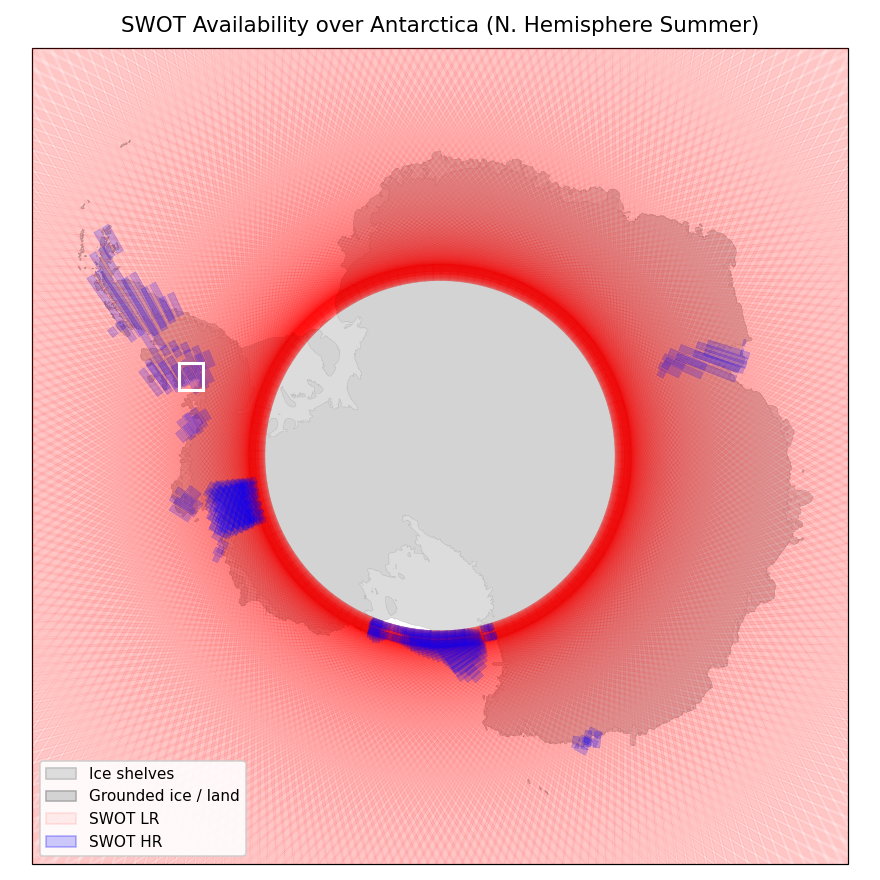

In [44]:
# --- Plot availability over Antarctica (EPSG:3031) ---
ps71 = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)

fig = plt.figure(figsize=(8, 8), dpi=110)
ax = plt.axes(projection=ps71)

# Antarctica basemap: grounded vs shelves
grounded_3031.plot(ax=ax, transform=ps71, color="lightgray", edgecolor="darkgray", linewidth=0.3, zorder=1)
shelves_3031.plot(ax=ax,   transform=ps71, color="gainsboro", edgecolor="silver", linewidth=0.25, zorder=2)

# SWOT LR (red), SWOT HR (blue)
# Build colors with different transparency for facecolor and edgecolor
swot_hr_fill  = to_rgba("blue", alpha=0.20)
swot_hr_edge  = to_rgba("blue", alpha=0.30)
swot_lr_fill  = to_rgba("red", alpha=0.06)
swot_lr_edge  = to_rgba("red", alpha=0.10)

# Note: Many HR/LR geometries are polygons; we use both facecolor and edgecolor lightly
lr_3031.plot(ax=ax, transform=ps71, color=swot_lr_fill, edgecolor=swot_lr_edge, linewidth=0.2, zorder=3)
hr_3031.plot(ax=ax, transform=ps71, color=swot_hr_fill, edgecolor=swot_hr_edge, linewidth=0.2, zorder=4)

bach_rect = plt.Rectangle((bach[0], bach[1]), bach[2] - bach[0], bach[3] - bach[1], 
                          zorder=5, linewidth=2, edgecolor="white", facecolor="none")
ax.add_patch(bach_rect)

# Crop axes to Antarctica
ax.set_xlim(-3000000, 3000000) # 3000 km2
ax.set_ylim(-3000000, 3000000)

legend_handles = [
    Patch(facecolor="gainsboro", edgecolor="silver", label="Ice shelves"),
    Patch(facecolor="lightgray", edgecolor="darkgray", label="Grounded ice / land"),
    Patch(facecolor=swot_lr_fill, edgecolor=swot_lr_edge, label="SWOT LR"),
    Patch(facecolor=swot_hr_fill, edgecolor=swot_hr_edge, label="SWOT HR"),
]
leg = ax.legend(handles=legend_handles, loc="lower left", frameon=True, framealpha=0.9)
for text in leg.get_texts():
    text.set_fontsize(10)

ax.set_title("SWOT Availability over Antarctica (N. Hemisphere Summer)", fontsize=14, pad=10)

plt.tight_layout()
plt.show()

# Compare SWOT and ICESat-2 elevations on Bach Ice Shelf
We can see that there is HR coverage over Bach Ice Shelf so we will compare SWOT heights there to ICESat-2. 

ICESat-2 is a photon-counting green laser altimeter. We can make this comparison because when measuring snow and ice surface heights, both SWOT (Ka band radar) and ICESat-2 (photon counting green laser) are considered surface sensing instruments. They penetrate to nearly equivalent depths into snow and ice, though Ka band radar **likely** penetrates millimeters to a few centimeters deeper into dry snow than ICESat-2 does. They are likely more indistinguishable for wet snow. More information about ICEsat-2 data products, mission, and tutorials is available in the [ICESat-2 Cookbook](https://icesat-2hackweek.github.io/icesat2-cookbook/). 

```{figure} ../ICESat2_ATL15_dhdt/images/Smith_2019_fig1.png 
:width: 80%
:align: center

ICESat-2 laser configuration (from [Smith and others, 2019](https://doi.org/10.1016/j.rse.2019.111352))
```

We will use what we learned in the [SWOT HR data access tutorial](https://book.cryointhecloud.com/swot-hr-access) to compare the [SWOT_L2_HR_Raster_100m](https://search.earthdata.nasa.gov/search/granules/collection-details?p=C3233942298-POCLOUD&pg[0][v]=f&pg[0][gsk]=-start_date&tl=1714336636.163!4!!) product to [ICESat-2's Land Ice Height, Version 6 (ATL06)](https://search.earthdata.nasa.gov/search/granules/collection-details?p=C2670138092-NSIDC_CPRD&pg[0][v]=f&pg[0][gsk]=-start_date&q=icesat-2%20atl06). 

**ATL06**:
- 17 m footprint
- Segments aggregate across 40 m of photos
- Segments acquired every 20 m along transect

To demonstrate a different `earthaccess` search method, we use a specific granule of SWOT data found using [Earthdata search](https://www.earthdata.nasa.gov/) based on it being a high quality pass when we plot it. For comparison, we search for all ICESAT-2 tracks in a specified bounding box and manually pick one ICESat-2 track that intersects the SWOT swath at our region of interest. 

::::{admonition} Learning objectives
:class: tip
By the end of this section, you will:
- Obtain **spatially coincident** ICESat-2 ATL06 and SWOT HR data  
- Apply **consistent geophysical corrections** across missions  
- **Advect** ICESat-2 tracks to the SWOT acquisition time using a velocity map  
- Plot a **side-by-side/map + cross-section** comparison over the **Bach Ice Shelf**
::::

:::{admonition} Prerequisites
:class: tip
- Earthdata login credentials
- The **Scripps Antarctica polygons** shapefile is available at `Antarctica_masks/scripps_antarctica_polygons_v1.shp` and downloaded in the previous section  
:::


# Imports, paths, and constants to get started


In [45]:
# --- Pip Install a few packages that are not in the default CryoCloud environment: --- 
%pip install -q pyTMD # For downloading and running the Circum-Antarctic Tidal Simulation (CATS) for tide corrections
%pip install -q icesat2_toolkit # For converting ICESat-2 time to GMT
%pip install -q cmap # For perceptually uniform colormaps
%pip install -q PyAstronomy # For date conversions
%pip install -q earthaccess==0.14

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


:::{note} Best practice: `%pip install library` within notebook
:class: dropdown
Ensures replicability for next person and that the library gets installed in the correct location
:::

In [49]:
# --- Imports ---
%matplotlib widget

from pathlib import Path
from itertools import chain
from concurrent.futures import ProcessPoolExecutor
import datetime as dt
import os, logging, warnings, tempfile, gzip, shutil

# Data and processing
import h5py
import s3fs
import fiona
import h5coro
import rasterio
import requests
import earthaccess
import numpy as np
import pandas as pd
import xarray as xr
import icesat2_toolkit
from io import BytesIO
import geopandas as gpd
import cartopy.crs as ccrs
from PyAstronomy import pyasl
from scipy.interpolate import RegularGridInterpolator

import pyTMD
import timescale  

# Plotting
import shapely
import shapefile
from shapely.plotting import plot_line
from shapely.geometry import LineString

from cmap import Colormap
import cartopy.crs as ccrs
from pyproj import CRS, Transformer

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# Quiet noisy logs
warnings.filterwarnings("ignore", message=".*ERROR parsing kml Style: No id.*", category=RuntimeWarning)
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)

In [50]:
# --- Study area --- 
DATADIR = Path("/home/jovyan/shared-public/SWOT/data") # Shared data files that cannot be streamed
GL_SHP   = DATADIR / "Antarctica_masks/scripps_antarctica_polygons_v1.shp" # Grounding line shapefile
BBOX = [-1_970_000, 490_000, -1_820_000, 670_000]  # PS71 [EPSG:3031] bounding box for Bach Ice Shelf
RIFT_BBOX = [-1_885_000, 570_000, -1_855_000, 590_000]  # PS71 [EPSG:3031] bounding box for rift of interest

PS71 = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)

tick_label_size = 16
legend_label_size = 18

::::{admonition} Login and basic helpers
:class: tip
We authenticate with **earthaccess** and define a few helper functions for coordinate transforms and tides.
::::


In [51]:
# --- Earthdata login (interactive once; persists to ~/.netrc) --- 
import earthaccess
auth = earthaccess.login(strategy="interactive", persist=True)
assert auth.authenticated, "Earthdata Login failed."

In [52]:
# Coordinate transforms
def xy2ll(x, y):
    """Convert PS71 (EPSG:3031) coordinates to WGS84 (EPSG:4326)"""
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy=True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat

def ll2xy(lon, lat):
    """Convert WGS84 (EPSG:4326) coordinates to PS71 (EPSG:3031)"""
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy=True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

def ps712utm(x, y, crs):
    """Convert UTM zone {crs} (SWOT native) to PS71 (EPSG:3031) coordinates"""
    crs_utm = CRS(f"EPSG:{crs}")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_xy, crs_utm, always_xy=True)
    utmx, utmy = ll_to_xy.transform(x, y)
    return utmx, utmy

# Colorbar Logic
def add_inset_colorbar(fig, ax, mappable, label,
                       anchor=(0.999, 0.90),  # (x, y) in axes fraction
                       width=3.0, height=0.9,  # inches
                       orientation="horizontal", extend=None, fontsize=tick_label_size):
    # outer box (absolute size in inches, 2-tuple anchor is OK)
    cbbox = inset_axes(ax, width=width, height=height,
                       bbox_to_anchor=anchor, bbox_transform=ax.transAxes, loc="upper right")
    
    for sp in cbbox.spines.values():
        sp.set_visible(False)
    cbbox.set_facecolor([0, 0, 0, 0.7])
    cbbox.set_xticks([]); cbbox.set_yticks([])

    # actual bar inside
    inner = inset_axes(cbbox, "92%", "20%", loc="center")
    cbar = fig.colorbar(mappable, cax=inner, orientation=orientation, extend=extend)
    cbar.outline.set_edgecolor("white"); cbar.outline.set_linewidth(1)
    cbar.ax.tick_params(labelsize=fontsize, color="white", labelcolor="white")
    cbar.set_label(label, fontsize=fontsize+2, color="white")
    if orientation == "horizontal":
        cbar.ax.xaxis.set_label_position("top")
    cbar.ax.minorticks_on(); cbar.ax.tick_params(which="minor", length=4, color="white")
    return cbar

::::{admonition} Load MOA mosaic for visualization
:class: tip
We'll stream the Mosaic of Antarctica Image Map to use as a basemap for all of our plots. 

**MODIS Mosiac of Antarctica 2008-2009 Image Map, Version 2** — from [NSIDC](https://nsidc.org/data/nsidc-0593/versions/2)

<https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa750_2009_hp1_v02.0.tif.gz>
::::

:::{note} Streaming: No download needed!
:class: dropdown
Because these are in the right formats (.tif) and stored using the best data practices (no authentication, CAPTCHA, or other barriers), we can use python to quickly read this data directly into memory without the need to download. 
:::

In [53]:
# --- MOA 2009 grayscale basemap (gzipped GeoTIFF) ---

# URL of the protected gzip file
moa_url = "https://daacdata.apps.nsidc.org/pub/DATASETS/nsidc0593_moa2009_v02/geotiff/moa750_2009_hp1_v02.0.tif.gz"

# Use Earthdata login stored in ~/.netrc (standard for requests)
session = requests.Session()
session.auth = requests.utils.get_netrc_auth(moa_url)

# Add user-agent to mimic a real browser
headers = {"User-Agent": "NASA Earthdata Python client"}

# Download and check for success
response = session.get(moa_url, headers=headers)
response.raise_for_status()

# Confirm content-type is not HTML (debug print)
if b"<html" in response.content[:100].lower():
    raise RuntimeError("Download returned HTML (login failed or wrong credentials?)")

# Decompress the GZip in memory
with gzip.GzipFile(fileobj=BytesIO(response.content)) as gz:
    tif_bytes = BytesIO(gz.read())

# Read with Rasterio from memory
with rasterio.MemoryFile(tif_bytes) as memfile:
    with memfile.open() as moa:
        bounds = moa.bounds
        left, bottom, right, top = bounds.left, bounds.bottom, bounds.right, bounds.top
        moa_dat = moa.read(1)

ext = (left, right, bottom, top)

::::{admonition} Get SWOT HR & determine ICESat-2 search window
:class: tip
We stream one **SWOT_L2_HR_Raster_100m_D** granule chosen over Bach Ice Shelf, then search **ATL06** within ± 9 days and within the box. We'll use the results of our ATL06 search to select one track crossing our rift of interest
::::

In [54]:
# --- SWOT HR granule (search via granule name) ---
search_days = 9

swot_results = earthaccess.search_data(
    short_name="SWOT_L2_HR_Raster_D",
    temporal=("2025-05-23", "2025-05-23"),
    granule_name="SWOT_L2_HR_Raster_100m_UTM18D_N_x_x_x_033_143_012F_20250523T232533_20250523T232551_PID0_01.nc",
)
swot_file = earthaccess.open(swot_results)[0]
ds_swot = xr.open_dataset(swot_file, engine="h5netcdf")

# Build LAT/LON polygon for ATL06 search
poly_xy = np.array([[RIFT_BBOX[0], RIFT_BBOX[1]],[RIFT_BBOX[2], RIFT_BBOX[1]],
                    [RIFT_BBOX[2], RIFT_BBOX[3]],[RIFT_BBOX[0], RIFT_BBOX[3]],[RIFT_BBOX[0], RIFT_BBOX[1]]])
poly_lon, poly_lat = xy2ll(poly_xy[:,0], poly_xy[:,1])
polygon_ll = np.c_[poly_lon, poly_lat].tolist()

# Time window: SWOT start/end ± 9 days
t0 = dt.datetime.strptime(ds_swot.time_granule_start, "%Y-%m-%dT%H:%M:%S.%fZ")
t1 = dt.datetime.strptime(ds_swot.time_granule_end,   "%Y-%m-%dT%H:%M:%S.%fZ")
atl06_window = (t0 - dt.timedelta(days=search_days), t1 + dt.timedelta(days=search_days))


atl06_results = earthaccess.search_data(short_name="ATL06",
                                        temporal=atl06_window,
                                        polygon=polygon_ll)
print(f'{len(atl06_results)} files found in time window in RIFT_BBOX')

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

3 files found in time window in RIFT_BBOX


::::{admonition} Read ATL06 beams (efficiently)
:class: tip
We’ll stream just the **ATL06 variables** we need from each file using `h5netcdf` + `s3fs` temporary credentials from **earthaccess**.
::::

In [55]:
# --- Read a subset of ATL06 beams and variables - 30 s ---
beam_roots = ["gt1l","gt1r","gt2l","gt2r","gt3l","gt3r"]

s3_creds = auth.get_s3_credentials(daac="NSIDC")
fs_nsidc = s3fs.S3FileSystem(
    key=s3_creds["accessKeyId"],
    secret=s3_creds["secretAccessKey"],
    token=s3_creds["sessionToken"],
)

def read_atl06_points(result):
    """Return a list of dicts (one per beam) with coords, heights, corrections."""
    out = []
    s3_url = result.data_links(access="direct")[0].replace("s3://","")
    for beam in beam_roots:
        try:
            with fs_nsidc.open(s3_url, mode="rb", cache_type="blockcache", block_size=4*1024*1024) as s3obj:
                ds_main = xr.open_dataset(s3obj, engine="h5netcdf",
                                          group=f"{beam}/land_ice_segments",
                                          driver_kwds={"rdcc_nbytes": 1024*1024},
                                          decode_times=False, phony_dims="sort")
                ds_dem  = xr.open_dataset(s3obj, engine="h5netcdf",
                                          group=f"{beam}/land_ice_segments/dem",
                                          driver_kwds={"rdcc_nbytes": 1024*1024},
                                          decode_times=False, phony_dims="sort")
                ds_geo  = xr.open_dataset(s3obj, engine="h5netcdf",
                                          group=f"{beam}/land_ice_segments/geophysical",
                                          driver_kwds={"rdcc_nbytes": 1024*1024},
                                          decode_times=False, phony_dims="sort")
                data = {
                    "lon": ds_main["longitude"].values,
                    "lat": ds_main["latitude"].values,
                    "h_li": ds_main["h_li"].values.astype("float32"),
                    "t_dt": ds_main["delta_time"].values,
                    "q":    ds_main["atl06_quality_summary"].values,
                    "geoid_h": ds_dem["geoid_h"].values.astype("float32"),
                    "geoid_free2mean": ds_dem["geoid_free2mean"].values.astype("float32"),
                    "tide_ocean": ds_geo["tide_ocean"].values.astype("float32"),
                    "dac": ds_geo["dac"].values.astype("float32"),
                    "tide_earth": ds_geo["tide_earth"].values.astype("float32"),
                    "tide_earth_free2mean": ds_geo["tide_earth_free2mean"].values.astype("float32"),
                    "tide_pole": ds_geo["tide_pole"].values.astype("float32"),
                    "tide_load": ds_geo["tide_load"].values.astype("float32"),
                    "beam": beam, "name": s3_url,
                }
                # Mask poor quality data
                bad = (data["q"] == 1) | (data["h_li"] > 3.0e38)
                data["h_li"][bad] = np.nan
                # PS71 coords
                data["x"], data["y"] = ll2xy(data["lon"], data["lat"])
                out.append(data)
        except Exception as exc:
            # Skip missing beams
            continue
    return out

atl06 = []
for r in atl06_results:
    atl06.extend(read_atl06_points(r))

# Convert delta_time -> decimal years using icesat2_toolkit
for d in atl06:
    dec = icesat2_toolkit.convert_delta_time(d["t_dt"])
    d["time"] = dec["decimal"]

print(f'{len(atl06)} beams loaded')

18 beams loaded


### Preview and choose ATL06 tracks to compare with SWOT

We’ll **plot a slice** of the `atl06` candidates on top of the SWOT swath and the MOA context map.  

Use the `is2_start`/`is2_end` indices to step through candidates until you find a track that best crosses your area of interest (e.g., a crevasse field). The cell prints the **granule filename** and **beam** for each plotted candidate so you can note the one you want to use in the next step.

::::{admonition} Tips
:class: tip
- Start with the full range and then narrow in using the ICESat-2 colormap to determine which track you want.  
- If the panel looks empty, verify the indices are within `len(atl06)`.  
::::

Previewing ATL06 candidates [0:18] out of total 18
gt1l  ATL06_20250515130244_09102710_007_01.h5
gt1r  ATL06_20250515130244_09102710_007_01.h5
gt2l  ATL06_20250515130244_09102710_007_01.h5
gt2r  ATL06_20250515130244_09102710_007_01.h5
gt3l  ATL06_20250515130244_09102710_007_01.h5
gt3r  ATL06_20250515130244_09102710_007_01.h5
gt1l  ATL06_20250520014201_09792712_007_01.h5
gt1r  ATL06_20250520014201_09792712_007_01.h5
gt2l  ATL06_20250520014201_09792712_007_01.h5
gt2r  ATL06_20250520014201_09792712_007_01.h5
gt3l  ATL06_20250520014201_09792712_007_01.h5
gt3r  ATL06_20250520014201_09792712_007_01.h5
gt1l  ATL06_20250524013336_10402712_007_01.h5
gt1r  ATL06_20250524013336_10402712_007_01.h5
gt2l  ATL06_20250524013336_10402712_007_01.h5
gt2r  ATL06_20250524013336_10402712_007_01.h5
gt3l  ATL06_20250524013336_10402712_007_01.h5
gt3r  ATL06_20250524013336_10402712_007_01.h5


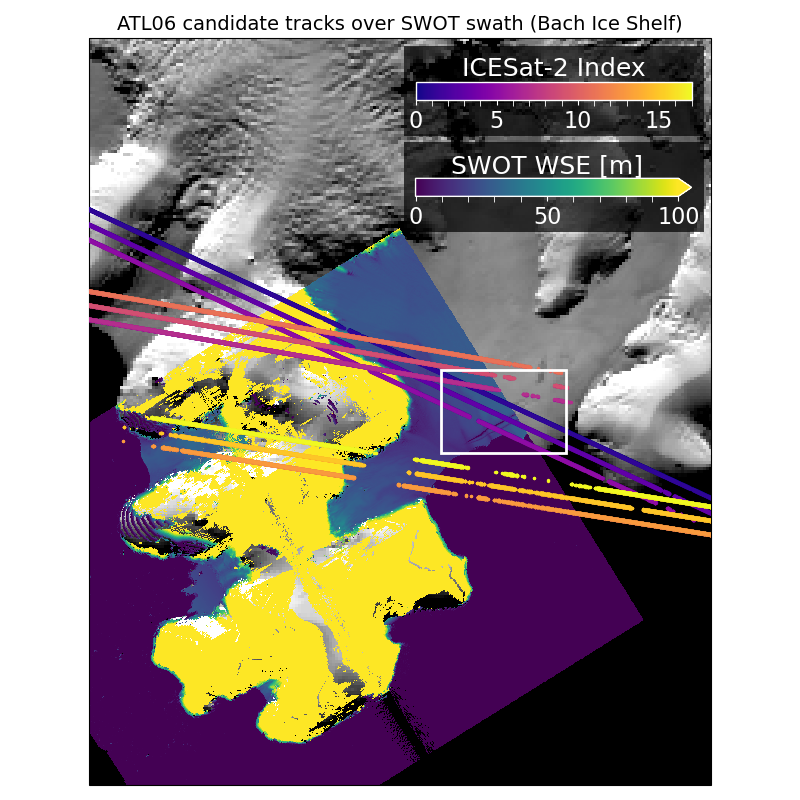

In [56]:
# --- Choose a slice of ATL06 candidates to preview (adjust as needed) ---
is2_start, is2_end = 0, 18  # tweak these indices

subset = atl06[is2_start:is2_end]
print(f"Previewing ATL06 candidates [{is2_start}:{is2_end}] out of total {len(atl06)}")
for d in subset:
    print(f"{d['beam']:>4}  {d['name'].split('/')[-1]}")

# --- Figure: MOA (gray) + SWOT swath (viridis) + ATL06 points ---
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=PS71)

# MOA basemap
ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)

# SWOT swath (water surface elevation)
wse = ds_swot["wse"]
utm = ccrs.UTM(zone=ds_swot.utm_zone_num, southern_hemisphere=True)
X, Y = np.meshgrid(wse["x"].values, wse["y"].values)
mesh = ax.pcolormesh(
    X, Y, wse.values,
    transform=utm, cmap="viridis", shading="auto",
    vmin=0, vmax=100, zorder=2
)

# ATL06 candidate tracks (colored by index within the slice)
cmap = plt.get_cmap("plasma")
n = max(1, len(subset))
for i, d in enumerate(subset):
    color = cmap(i / (n - 1) if n > 1 else 0.5)
    ax.scatter(d["x"], d["y"], s=2, color=color, transform=PS71, zorder=3)
# Convert cmap into ScalarMappable for colorbar
norm = plt.Normalize(vmin=0, vmax=n - 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([]) 

bach_rect = plt.Rectangle((RIFT_BBOX[0], RIFT_BBOX[1]), RIFT_BBOX[2] - RIFT_BBOX[0], RIFT_BBOX[3] - RIFT_BBOX[1], 
                          zorder=5, linewidth=2, edgecolor="white", facecolor="none")
ax.add_patch(bach_rect)

# View & labels
ax.set_xlim(BBOX[0], BBOX[2])
ax.set_ylim(BBOX[1], BBOX[3])
ax.set_title("ATL06 candidate tracks over SWOT swath (Bach Ice Shelf)", fontsize=14)

# Colorbar for SWOT Swath
add_inset_colorbar(fig, ax, mesh, "SWOT WSE [m]", anchor=(0.999, 0.87), extend="max")
# ICESat-2 tracks colorbar
add_inset_colorbar(fig, ax, sm, "ICESat-2 Index", anchor=(0.999, 0.999))

plt.tight_layout()
plt.show()

::::{admonition} Pick a track and advect it to SWOT time
:class: tip
We’ll select a beam/granule that crosses the crevasse field and **advect** the ICESat-2 points to the **SWOT acquisition time** using the MEaSUREs ice velocity grid.

**MEaSUREs Antarctica Ice Velocity**  — from [NSIDC](https://nsidc.org/data/nsidc-0484/versions/2)

<https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/MEASURES/NSIDC-0484/2/1996/01/01/antarctica_ice_velocity_450m_v2.nc>
::::

In [57]:
# --- Find granule matching ATL06_20241213201922_13522510_006_01.h5 --- 
gran = 'ATL06_20250515130244_09102710_007_01.h5'
beam = 'gt2r'
is2_tracks_to_use = []
for i, data in enumerate(atl06):
    if gran in data['name'] and beam in data['beam']:
        is2_tracks_to_use.append(atl06[i])

assert is2_tracks_to_use, 'No tracks found' # Check at least one track chosen

In [58]:
# --- Stream MeASUREs ice velocity data via earthaccess (NSIDC-0484), 450 m grid ---
v_results = earthaccess.search_data(short_name="NSIDC-0484", 
                                    cloud_hosted=True,
                                    temporal=("1996-01-01","1996-01-02"), 
                                    count=1)

v_file = earthaccess.open(v_results)[0]
vel = xr.open_dataset(v_file)

# Crop a margin around our box; compute magnitude for plotting
off = 10_000
v_crop = vel.sel(x=slice(BBOX[0]-off, BBOX[2]+off),
                 y=slice(BBOX[3]+off, BBOX[1]-off))
vel_mag = np.hypot(v_crop.VX, v_crop.VY)  # m/yr
oslo = Colormap("crameri:oslo").to_matplotlib() # Velocity colormap

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

::::{admonition} Notes on advection
:class: tip
- Create regular grid interpolators to speed up running the advection code (~10x speed up over using native grid)
- Advect ICESat-2 to location at time of SWOT data collection 
- Using velocity model resolution makes it so we do not introduce error
- Only running this for one IS2 beam, but it is set up to interpolate for as many beams as you want
::::

In [61]:
# --- Advect ICESat-2 to location at time of SWOT data collection ---

# Create regular grid interpolators to speed up running the advection code (~10x speed up over using native grid)
def prep_velocity_interpolators(vel):
    vx_interp = RegularGridInterpolator((vel.y.values[::-1], vel.x.values),
                        vel["VX"].values[::-1, :],bounds_error=False,fill_value=np.nan)
    vy_interp = RegularGridInterpolator((vel.y.values[::-1], vel.x.values),
                        vel["VY"].values[::-1, :],bounds_error=False,fill_value=np.nan)
    return vx_interp, vy_interp

for track in is2_tracks_to_use:
    # Copy arrays so we don't mutate the originals
    start_x = track["x"].copy()
    start_y = track["y"].copy()
    start_time = track["time"].copy()      # decimal years (one per point)

    # Spatial mask to the study bounding box (BBOX: [xmin, ymin, xmax, ymax])
    mask = (
        (start_x > BBOX[0]) &
        (start_x < BBOX[2]) &
        (start_y > BBOX[1]) &
        (start_y < BBOX[3])
    )
    # Keep full array length; mark points outside the box as NaN in X
    # (Y is left unchanged to preserve indexing; NaNs in X will propagate during updates)
    start_x[~mask] = np.nan

    # Convert decimal year → Python datetime for each sample
    start_time = [pyasl.decimalYearGregorianDate(t) for t in start_time]

    # Integration setup
    target_time = t0 - dt.timedelta(days=0)   # SWOT target time (t0); minus 0 keeps semantics
    step_size = 1 / 365                       # years per step (1 day)

    # For each point, compute time difference to target, then number of steps
    steps = [(target_time - t) for t in start_time]  # list of timedeltas (can be ±)
    steps = [int( td.total_seconds() / (365 * 24 * 60 * 60) / step_size ) for td in steps]
    
    # Use the sign of the FIRST point's step count to set direction (forward or backward in time)
    step_size = np.sign(steps[0]) * step_size
    # Integrate a UNIFORM number of steps for all points (assumes similar times)
    steps = np.abs(steps)

    # Velocity interpolators on the cropped grid
    # v_crop has coordinates (y, x). Arrays are stored row-major with y decreasing,
    # so the helper flips y when building RegularGridInterpolator.
    vx_interp, vy_interp = prep_velocity_interpolators(v_crop)

    # Euler integration (meters per year * years per step = meters per step)
    x = start_x.copy()
    y = start_y.copy()
    for _ in range(steps[0]):                 # same number of steps for every point
        # Sample velocity at current positions; inputs are (y, x)
        vx = vx_interp((y, x))                # meters / year
        vy = vy_interp((y, x))
        # Update positions; NaNs remain NaN and will propagate
        x = x + vx * step_size
        y = y + vy * step_size

    # Store advected coordinates back on the track
    track["x_advected"] = x
    track["y_advected"] = y

## Apply comparable geophysics & interpolate SWOT along-track

We bring heights to a consistent reference, then interpolate the SWOT **wse** at the **advected** ICESat-2 points (in the granule’s UTM zone).

::::{admonition} Tide corrections from CATS2008
:class: tip
ICESat-2 and SWOT provide elevations at different tidal heights because the data was collected at different times. We model the tides at the time of acquisition from both SWOT and ICESat-2 and subtract the tide elevation from the data to ensure a fair comparison. 

We use the CATS2008-v2023 tide model to correct for tides in SWOT and ICESat-2. CATS2008 is a circum-Antarctic high-resolution regional inverse ocean model. The model accounts for ocean cavities under the floating ice shelves so it performs more accurately that other tide models around Antarctica.

PyTMD is the python library that runs the model. PyTMD needs a local copy of the model grid. We fetch it once from the public S3 bucket and place it in PyTMD’s data path.
::::

In [62]:
# --- Ensure CATS2008-v2023 is available locally for PyTMD ---
fs = s3fs.S3FileSystem(anon=True)
pyTMD_path = pyTMD.utilities.get_data_path("data")
model = pyTMD.io.model(pyTMD_path, verify=False).elevation("CATS2008-v2023")
model.grid_file.parent.mkdir(parents=True, exist_ok=True)

if not model.grid_file.exists():
    with fs.open("pytmd/CATS2008_v2023/CATS2008_v2023.nc", "rb") as fin, \
         open(model.grid_file, "wb") as fout:
        shutil.copyfileobj(fin, fout)
model.grid_file.exists()

True

::::{admonition} Computing tide corrections
:class: tip
We compute tides in two steps that we have put into this helper function `compute_tides` that sets up the model based on the lat/lons of the study area and then predicts the tides and their minor consituents for that region.
::::

In [63]:
# Tides
def compute_tides(model, lons, lats, datetimes):
    """
    Computes the tides at given locations and times using PyTMD.

    Parameters
    model: PyTMD.model
         Tide model
    lons: list[float]
         Geodetic longitude in EPSG:4326
    lats: list[float]
         Geodetic latitude in EPSG:4326
    datetimes: list[datetime.datetime]
         Datetime to calculate tides

    Returns
    tides - list[float]
         Tide elevations in cm at locations and times sepcified
    """
    years  = np.array([d.year for d in datetimes])
    months = np.array([d.month for d in datetimes])
    days   = np.array([d.day for d in datetimes])
    hours  = np.array([d.hour for d in datetimes])
    minutes= np.array([d.minute for d in datetimes])

    tide_time = timescale.time.convert_calendar_dates(years, months, days, hours, minutes)

    # Setup model
    constituents = pyTMD.io.OTIS.read_constants(model.grid_file, model.model_file,
                                         model.projection, type=model.type,
                                         grid=model.format, apply_flexure=False)
    c = constituents.fields
    amp, ph, _ = pyTMD.io.OTIS.interpolate_constants(np.atleast_1d(lons),
                                                     np.atleast_1d(lats), constituents,
                                                     type=model.type, method="spline",
                                                     extrapolate=True)
    cph = -1j * ph * np.pi / 180.0
    hc = amp * np.exp(cph)

    # Calculate tides and infer minor constitutents at each location and time
    tides = []
    for i in range(len(datetimes)):
        TIDE = pyTMD.predict.map(tide_time[i], hc, c, deltat=0, corrections=model.format)
        MINOR = pyTMD.predict.infer_minor(tide_time[i], hc, c, deltat=0, corrections=model.format)
        t_cm = (TIDE.data + MINOR.data) * 100.0
        tides.append(t_cm.astype("float32"))
    return np.array(tides) 

In [64]:
# --- Find tide corrections using CATS at times of interest - 1m 29s --- 

# Swot and ICESat-2 times
tide_times = [
    t0,
    pyasl.decimalYearGregorianDate(is2_tracks_to_use[0]["time"][0]),
]
sats = ["SWOT", "IS2"]
data = is2_tracks_to_use[0]
data["lon_advected"], data["lat_advected"] = xy2ll(data["x_advected"], data["y_advected"])

for tide_time, satellite in zip(tide_times, sats):
    tide_results = np.array(
        compute_tides(model, data["lon_advected"], data["lat_advected"], [tide_time])).T
    data[f"tide_{satellite}"] = tide_results

data["tide_IS2"] = data["tide_IS2"].astype("float32").squeeze()
data["tide_SWOT"] = data["tide_SWOT"].astype("float32").squeeze()

::::{admonition} Geophysical corrections to ICESat-2 for fair comparison to SWOT
:class: tip
In Version D, SWOT HR Raster variable ```wse``` has the following corrections applied:
```python
wse = H - geoid_height - solid_earth_tide - load_tide - pole_tide
```
where H is the surface elevation above the WGS84 reference ellipsoid. To compare to SWOT, ICESat-2 ATL06 Version 7 elevation ```h_li``` does not include these corrections by default and must be corrected in a similar way. We apply the following corrections to ```h_li```:
```python
h_li_corrected = h_li - geoid_h + geoid_free2mean - tide_earth - tide_pole - tide_load
```
This mirrors the correction applied by SWOT except for the ```geoid_free2mean``` term, which arises because the SWOT geoid is in the mean tide system while the ICESat-2 geoid is in the free tide system.

Use these links for more information about geophysical corrections for [SWOT](https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/web-misc/swot_mission_docs/pdd/D-56416_SWOT_Product_Description_L2_HR_Raster_20250224a_RevC_clean_sig_final.pdf) and [ICESat-2](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_atl03_atbd_v007.pdf). See also this [excellent reference](https://nsidc.org/sites/default/files/documents/technical-reference/icesat2_comparison-guide_r007.pdf) about comparing ICESat-2 with SWOT. Note that ICESat-2 and SWOT compute some of their geophysical corrections differently, making this comparison not perfect. The proper corrections will also evolve as product versions change.
::::

In [66]:
# --- Apply geophysical corrections to ICESat-2 heights for fair comparison to SWOT --- 
data["h_li_corrected"] = (
    data["h_li"]
    - data["geoid_h"]
    + data["geoid_free2mean"]
    - data["tide_earth"]
    - data["tide_pole"]
    - data["tide_load"]
)

::::{admonition} Interpolating SWOT swath along ICESat-2 track
:class: tip
Because the centers of SWOT pixels do not exactly align with ICESat-2 observations, we interpolate SWOT to where ICESat-2 observations were measured.
::::

In [67]:
# --- Interpolate SWOT swath along icesat-2 track --- 

# Create arrays to hold interpolated values
overall_wse = np.zeros_like(data["x_advected"])
overall_wse[:] = np.nan
overall_wse_sigma = np.zeros_like(data["x_advected"])
overall_wse_sigma[:] = np.nan

wse = ds_swot["wse"]
wse_sigma = ds_swot["wse_uncert"]

# Convert icesat2 to utm, and interpolate SWOT advected data
x_utm = wse["x"].values
y_utm = wse["y"].values
advected_x_utm, advected_y_utm = ps712utm(data["x_advected"], data["y_advected"], utm.to_epsg())

advected_x_utm = xr.DataArray(advected_x_utm, dims=["points"])
advected_y_utm = xr.DataArray(advected_y_utm, dims=["points"])

x_utm = wse["x"].values
y_utm = wse["y"].values

interpolated_wse = wse.interp(
    x=advected_x_utm,
    y=advected_y_utm,
    method="linear",
    kwargs={"fill_value": np.nan},
).compute()
interpolated_wse_sigma = wse_sigma.interp(
    x=advected_x_utm,
    y=advected_y_utm,
    method="linear",
    kwargs={"fill_value": np.nan},
).compute()

#Put all non-nan values into overall_wse
# If there are no SWOT data values where we have IS2 data, add a nan 
mask = np.isnan(overall_wse) & ~np.isnan(interpolated_wse)
# Only update at those places
overall_wse[mask] = interpolated_wse[mask]
overall_wse_sigma[mask] = interpolated_wse_sigma[mask]

# Compute +- 2 std
lower = overall_wse - 2 * overall_wse_sigma
upper = overall_wse + 2 * overall_wse_sigma

# Cropping data to the rift plot area
min_mask = -1872000
max_mask = -1865000
x_mask = (data["x_advected"] > min_mask) & (
    data["x_advected"] < max_mask
)

In [68]:
# --- Apply tide corrections to both datasets and uncertainty bounds ---
data["is2_tidecorrected"] = data["h_li_corrected"] - data["tide_IS2"] / 100
data["swot_tidecorrected"] = overall_wse - data["tide_SWOT"] / 100
data["swot_lower"] = lower - data["tide_SWOT"] / 100
data["swot_upper"] = upper - data["tide_SWOT"] / 100

::::{admonition} Plot: map + cross-section
:class: tip
We’ll show a **context map** (Advected ICESat-2 Track over SWOT Elevation) and a **cross-section** comparing corrected heights for the section of ICESat-2 track in orange. 
::::

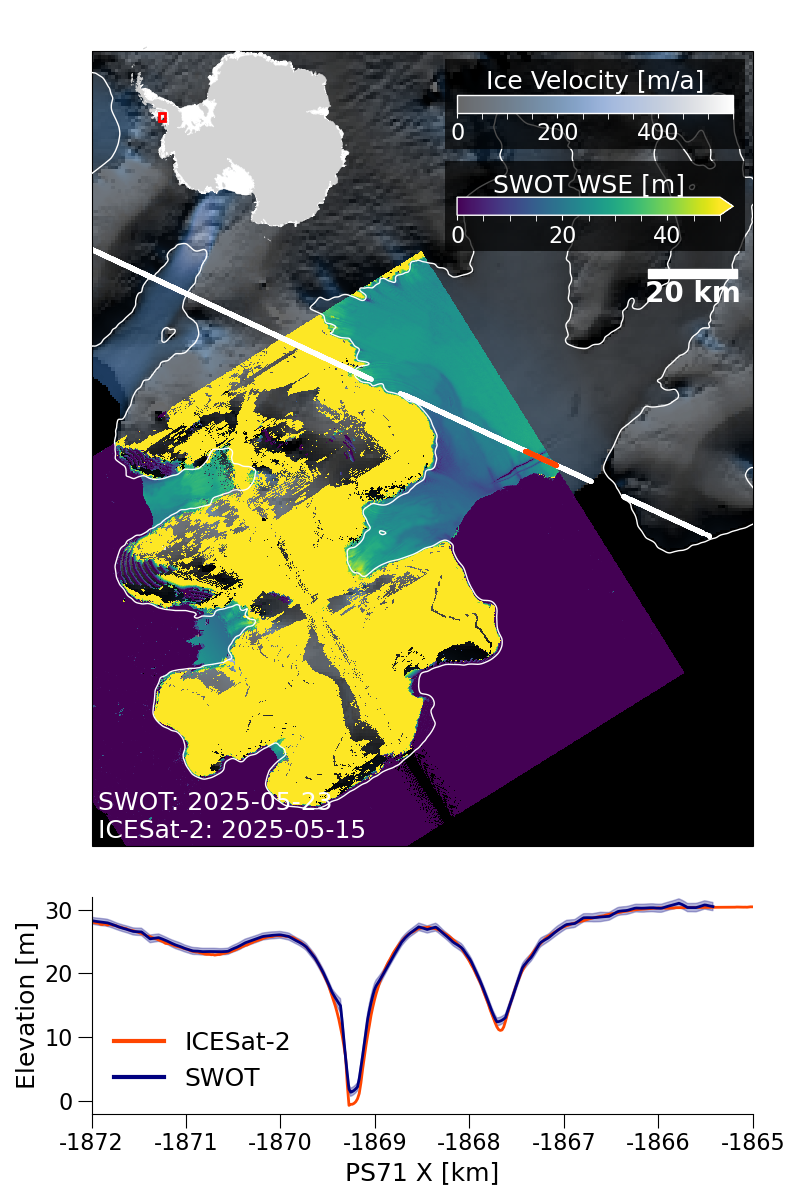

In [69]:
# Plot comparison
label = "Elevation [m]"
vmin = 0
vmax = 50

fig = plt.figure(figsize=(8, 12))

utm = ccrs.UTM(zone=ds_swot.utm_zone_num, southern_hemisphere=True)
ps71_projection = ccrs.Stereographic(central_latitude=-90, central_longitude=0, true_scale_latitude=-71)
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = fig.add_subplot(gs[0], projection=ps71_projection)

# Map View
ax.imshow(moa_dat, extent=ext, cmap="gray", vmin=15000, vmax=17000)
cb = ax.imshow(vel_mag, cmap=oslo, 
               extent=[vel_mag["x"].min(), vel_mag["x"].max(), vel_mag["y"].min(), vel_mag["y"].max()],
               origin="upper", alpha=0.6, vmin=0, vmax=550)

grounded_3031.plot(ax=ax, transform=ps71, color="none", edgecolor="white", linewidth=1, zorder=4)

wse = ds_swot['wse']
x = wse["x"].values
y = wse["y"].values

X, Y = np.meshgrid(x, y)
mesh = ax.pcolormesh(X, Y, wse.values, transform=utm, cmap="viridis", shading="auto", vmin=vmin, vmax=vmax)

ax.scatter(data["x_advected"], data["y_advected"], color="white", s=5, transform=ps71_projection)

x_plotting = data["x_advected"][x_mask]
y_plotting = data["y_advected"][x_mask]
ax.scatter(x_plotting, y_plotting, color="orangered", s=5, transform=ps71_projection)

# Cross section
ax2 = fig.add_subplot(gs[1])

ax2.plot(data["x_advected"], data["is2_tidecorrected"], 
         color="orangered", linewidth=2, label="ICESat-2")
ax2.plot(data["x_advected"], data["swot_tidecorrected"],
         color="navy", linewidth=2, label="SWOT")
ax2.fill_between(data["x_advected"], data["swot_lower"], 
         data["swot_upper"], color="navy", alpha=0.3)

# SWOT Swath colorbar
add_inset_colorbar(fig, ax, mesh, label="SWOT WSE [m]", anchor=(0.999, 0.87), extend="max")

# Ice Velocity colorbar
add_inset_colorbar(fig, ax, cb, label="Ice Velocity [m/a]", anchor=(0.999, 0.999))

# Prettify panel 1
ax.set_xlim(BBOX[0] + 1000, BBOX[2] - 1000)
ax.set_ylim(BBOX[1] + 1000, BBOX[3] - 1000)

# Scalebar
scalebar = AnchoredSizeBar(ax.transData, 20000, "20 km", "lower right", pad=0.1, 
                           sep=1, color="white", frameon=False, size_vertical=2000,
                           fontproperties=mpl.font_manager.FontProperties(size=20, weight="bold"), label_top=False)

# Antarctica Inset
inset = fig.add_axes([0.15, 0.73, 0.3, 0.3], projection=ps71_projection)  # [left, bottom, width, height]
inset.patch.set_facecolor("none")
for spine in inset.spines.values():
    spine.set_visible(False)
inset.set_xticks([])
inset.set_yticks([])

grounded_3031.plot(ax=inset, transform=ps71, color="lightgray", edgecolor="lightgray", linewidth=0.3, zorder=1)
shelves_3031.plot(ax=inset,   transform=ps71, color="white", edgecolor="white", linewidth=0.3, zorder=2)

rect = plt.Rectangle((BBOX[0], BBOX[1]), BBOX[2] - BBOX[0], BBOX[3] - BBOX[1],
                     zorder=3, linewidth=2, edgecolor="red", facecolor="none")
inset.add_patch(rect)
ax.add_artist(scalebar)
scalebar.set_bbox_to_anchor((0.99, 0.67), transform=ax.transAxes)

# Time Labels
ax.text(0.01, 0.01, "SWOT: 2025-05-23\nICESat-2: 2025-05-15", transform=ax.transAxes, fontsize=legend_label_size, color="white")

# Polish panel 2
ax2.set_xlabel("PS71 X [km]", fontsize=legend_label_size)
ax2.set_ylabel("Elevation [m]", fontsize=legend_label_size)
KM_SCALE = 1e3
ticks_x = ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x / KM_SCALE))
ax2.xaxis.set_major_formatter(ticks_x)
ax2.tick_params(axis="both", which="major", labelsize=tick_label_size, size=10)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.set_xlim(np.nanmin(data["x_advected"]), np.nanmax(data["x_advected"]))
ax2.set_xlim(min_mask, max_mask)  
ax2.set_ylim(-2, 32)

# Legend
handles = [
    Line2D([0], [0], color="orangered", linewidth=2, label="ICESat-2"),
    Line2D([0], [0], color="navy", linewidth=2, label="SWOT"),
    Patch(facecolor="navy", alpha=0.3, label="SWOT Uncertainty"),
]

ax2.legend(fontsize=legend_label_size, loc="lower left", handles=handles[:1] + [handles[1]])
leg = ax2.get_legend()
for line in leg.get_lines():
    line.set_linewidth(3)
leg.get_frame().set_edgecolor("white")
leg.get_frame().set_linewidth(1)

fig.tight_layout()

:::{admonition} Summary
:class: tip
You loaded **coincident SWOT HR and ICESat-2 ATL06**, brought them to a **comparable reference** via geophysical corrections, **advected** the ICESat-2 track to SWOT time using a velocity mosaic, and produced a **map + cross-section** comparison over the **Bach Ice Shelf**.  
:::